# Wave Statistics based on wave-by-wave analysis
Here, we will load a time serie of water elevation recorded by a buoy offshore the US coast. We abandon the field of synthetic waves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import find_peaks

In [34]:

def create_UTC_axis(ds_xyz, arrayIndex):

    """
    Purpose: Create the time axis associated to the motion along x, y, and z dimension
    ----------
    inputs:
    --------
    ds_xyz: the xarray dataset that contain the motions
    arrayIndex: The array of second
    output:
    --------
    time_array: datetime64 object in s. 
    """
    
    arrayIndex = xr.DataArray(arrayIndex, attrs={'units': 'nb_of_obs'}).astype('timedelta64[s]')

    
    sample_rate_sec = xr.DataArray(ds_xyz.xyzSampleRate.values, attrs={'units': 's'}).astype('timedelta64[s]')
    filter_delay_sec = xr.DataArray(ds_xyz.xyzFilterDelay.values, attrs={'units': 's'}).astype('timedelta64[s]')
    time_axis = xr.DataArray(arrayIndex/sample_rate_sec, attrs={'units': 's'}).astype('timedelta64[s]')

    time_array = ds_xyz.xyzStartTime.values + time_axis - filter_delay_sec
    return time_array


### Load Data

In [47]:
# You can visit these website if you want to deal with OPeNDAP format (need internet)
# file_url_data = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/029p1_xy.nc?xyzStartTime,xyzSampleRate,xyzFilterDelay,xyzZDisplacement[0:1:10000],xyzXDisplacement[0:1:10000],xyzYDisplacement[0:1:10000],metaWaterDepth'
# file_url_param = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/029p1_rt.nc?waveTime[0:1:1848],waveTp[0:1:1848]'

file_url_data = './data/motion_wave_data_cdip.nc'
file_url_param = './data/spectral_wave_data_cdip.nc'

ds_buoy = xr.open_dataset(file_url_data)
ds_operationel = xr.open_dataset(file_url_param)
Nobs = 2304

ds_buoy = ds_buoy.sel(xyzCount = slice(0, Nobs))
arrayIndex = np.linspace(0, Nobs, Nobs) # an array of 30 min
time_UTC = create_UTC_axis(ds_buoy, arrayIndex)

elevation =  ds_buoy.xyzZDisplacement[:len(arrayIndex)] # work on a 30 min window

In [37]:
# Content of the Dataset
ds_buoy

<xarray.Dataset> Size: 865kB
Dimensions:              (sourceCount: 100000, xyzCount: 2304)
Coordinates:
    metaDeployLatitude   float32 4B ...
    metaDeployLongitude  float32 4B ...
Dimensions without coordinates: sourceCount, xyzCount
Data variables: (12/16)
    sourceFilename       (sourceCount) object 800kB ...
    xyzStartTime         datetime64[ns] 8B 2025-09-06T22:00:00
    xyzSampleRate        float32 4B 1.28
    xyzFilterDelay       float32 4B 133.3
    xyzFlagPrimary       (xyzCount) float32 9kB ...
    xyzFlagSecondary     (xyzCount) float32 9kB ...
    ...                   ...
    metaStationName      |S28 28B ...
    metaPlatform         |S1 1B ...
    metaInstrumentation  |S1 1B ...
    metaWaterDepth       float32 4B ...
    metaDeclination      float32 4B ...
    metaGridMapping      |S1 1B ...
Attributes: (12/66)
    naming_authority:                edu.ucsd.cdip
    keywords_vocabulary:             Global Change Master Directory (GCMD) Ea...
    date_created:                    2025-10-17T16:31:11Z
    date_issued:                     2025-10-17T16:31:11Z
    date_modified:                   2025-10-17T16:31:11Z
    creator_name:                    Coastal Data Information Program, SIO/UCSD
    ...                              ...
    time_coverage_resolution:        PT0.78S
    source:                          insitu observations
    instrument:                      metaInstrumentation
    platform:                        wave_buoy
    platform_vocabulary:             http://mmisw.org/ont/ioos/platform
    platform_name:                   POINT REYES, CA BUOY - 029p1

### Plot recorded elevation

Text(0, 0.5, 'Buoy Elevation along the z axis [m]')

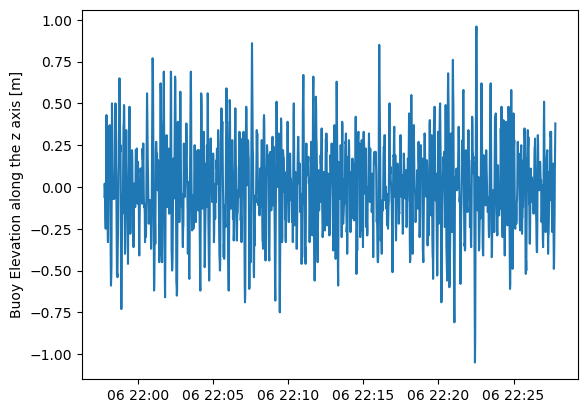

In [4]:
fig, ax = plt.subplots()
ax.plot(time_UTC,elevation)
ax.set_ylabel('Buoy Elevation along the z axis [m]')

Here, we analyze a physical (mechanical) wave signal. Our objective is to extract its main characteristics — amplitude, wavelength (or period), and, when possible, direction — in order to provide consistent and interpretable quantities that describe the overall state of the wave field (e.g., whether the waves are large or small, steep or gentle).

- Direction: since we are dealing with a one-dimensional signal, the propagation direction cannot be determined (we cannot distinguish whether the waves travel northward, eastward, etc.).
  
- Wavelength / Period: these can be estimated by counting the number of wave crests (or zero crossings) along the entire signal.

  
- Amplitude: to characterize the wave amplitude, we must decide which crests (i.e., portions of the signal where the elevation$>$0) to consider as representative of the overall wave field.


In [39]:
Hmax = elevation.max()
H_mean = elevation.mean()
print(f'The highest crest reach {Hmax.values} m')
print(f'The mean elevation is equal to {H_mean.values} m')

The highest crest reach 0.9599999785423279 m
The mean elevation is equal to 0.00022569469001609832 m


 Spot peaks in the 1D signal

In [41]:
count_peak = find_peaks(elevation)[0] # found peaks of the signal, no thresholds. Consider all peaks

wave_period_estimated = 1800/len(count_peak)
print(f'We have {len(count_peak)} peaks over 1800 sec. So the wave period seems to be equal to {wave_period_estimated} sec')

We have 380 peaks over 1800 sec. So the wave period seems to be equal to 4.7368421052631575 sec


In [49]:
waveTime_sel = np.datetime64('2025-09-06T21:30')
ds_operationel_sel = ds_operationel.sel(waveTime = waveTime_sel, method ='nearest')
print(f'The associated period provided by the CDIP team for the present record is equal to: {ds_operationel_sel.waveTp.values} s')

The associated period provided by the CDIP team for the present record is equal to: 13.333333015441895 s


### Significant Wave Height

For the amplitude one can see that the mean elevation is almost equal to 0 m, because the elevation is oscillating around a zero level. One solution could be to provide the highest wave crest (equal to 1.92 m here-distance crest/trough). However there are only ~ 3 crests that reach this elevation. So it raises the question about the relevance of such indicator...

In the wave comunity, we use the quantity called the *Significant Wave Height* (named $H_s$ or  SWH). The term *Significant* is used because it represent, more or less, the wave amplitude of a given wave field from a external human observer. This quantity relied on strong and rigorous statistics and can be approximated to the *mean of a 1/3 highest distance trough-crest observed along a record*

In [44]:
counts, bins = np.histogram(2*abs((elevation[elevation>0].values)), bins = 50)

In [45]:
cdf = np.cumsum(counts)
cdf = cdf / cdf[-1]  # normalize to [0, 1]
idx = np.searchsorted(cdf, 2/3)  # lower bound of highest 1/3 waves
SWH = np.nanmean(bins[idx:])
print(f'The Significant Wave Height is equal to {SWH} m')

The Significant Wave Height is equal to 1.2170000076293945 m


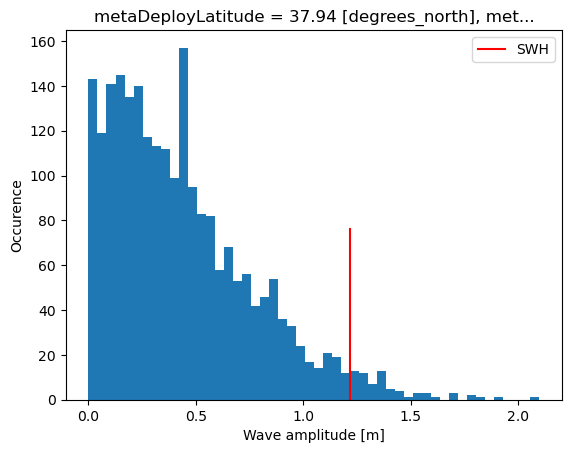

In [46]:
fig, ax = plt.subplots()
# for simplicity I assume the crest and the trough as symmetric, which is not true!
(2*abs(elevation)).plot.hist(ax = ax, bins = 50)
plt.plot([np.mean(bins[idx:]), np.mean(bins[idx:])], [0, counts.max()], color = 'r', label = 'SWH')
ax.set_xlabel('Wave amplitude [m]')
ax.set_ylabel('Occurence')
ax.legend()

Here the SWH is slightly overestimated due to the assumption that the distance between 0 and the troughs and 0 and the crests are identical.

We have seen that doing statistics on individual waves yields very different mean wave period than the wave period provided by the team that manage the wave buoy; for the same recording? Why?  We investigate it in the next notebook